## Random Forest Model Training

This notebook outlines the steps to recreate and train a random forest model.

Confusion matrix plot saved to: /mnt/d/Model-heart-disease/images_ConfusionMatrix/fiveso/fold_1_confusion_matrix_rf_test.png
Confusion matrix plot saved to: /mnt/d/Model-heart-disease/images_ConfusionMatrix/fiveso/fold_1_confusion_matrix_rf_train.png
Confusion matrix plot saved to: /mnt/d/Model-heart-disease/images_ConfusionMatrix/fiveso/fold_2_confusion_matrix_rf_test.png
Confusion matrix plot saved to: /mnt/d/Model-heart-disease/images_ConfusionMatrix/fiveso/fold_2_confusion_matrix_rf_train.png
Confusion matrix plot saved to: /mnt/d/Model-heart-disease/images_ConfusionMatrix/fiveso/fold_3_confusion_matrix_rf_test.png
Confusion matrix plot saved to: /mnt/d/Model-heart-disease/images_ConfusionMatrix/fiveso/fold_3_confusion_matrix_rf_train.png
Confusion matrix plot saved to: /mnt/d/Model-heart-disease/images_ConfusionMatrix/fiveso/fold_4_confusion_matrix_rf_test.png
Confusion matrix plot saved to: /mnt/d/Model-heart-disease/images_ConfusionMatrix/fiveso/fold_4_confusion_matrix_rf_train.

/tmp/ipykernel_2963/3007890409.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 4))  # Smaller figure size


Average confusion matrix plot saved to: /mnt/d/Model-heart-disease/images_ConfusionMatrix/average_confusion_matrix_rf_test.png


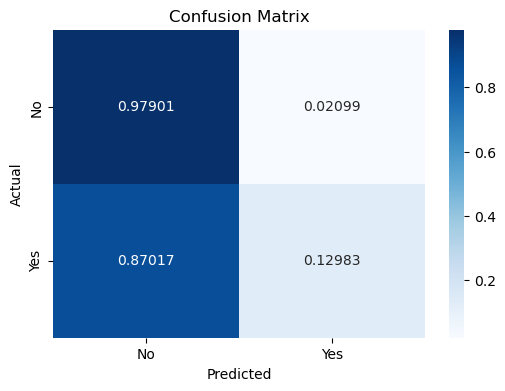

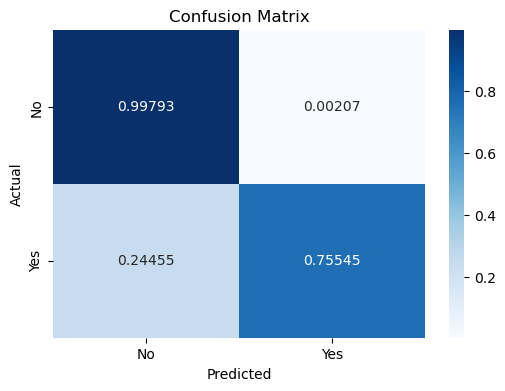

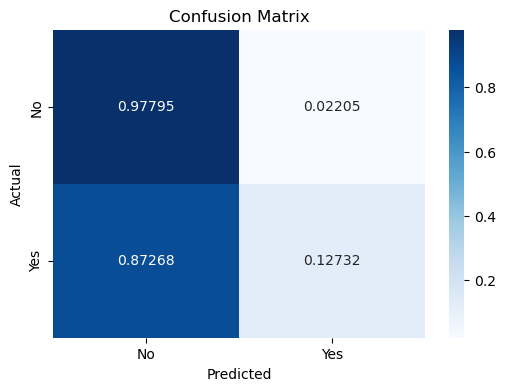

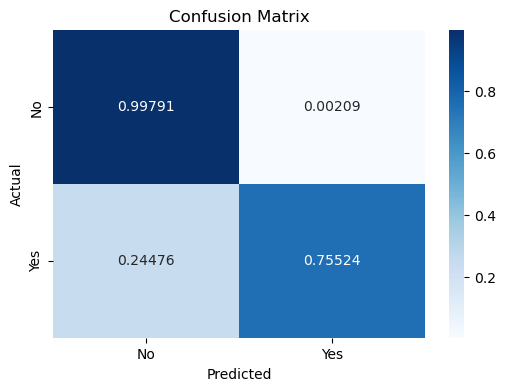

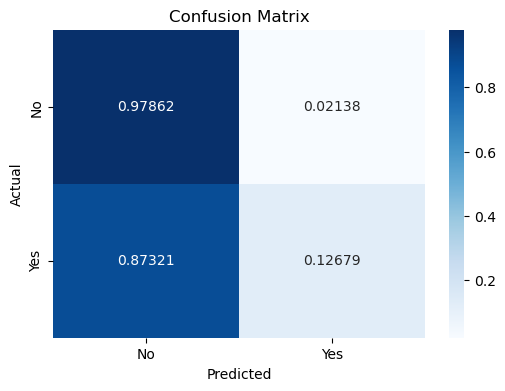

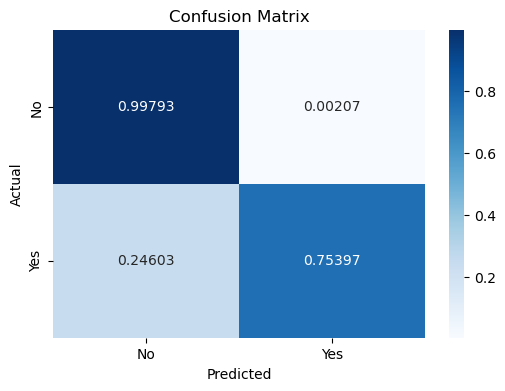

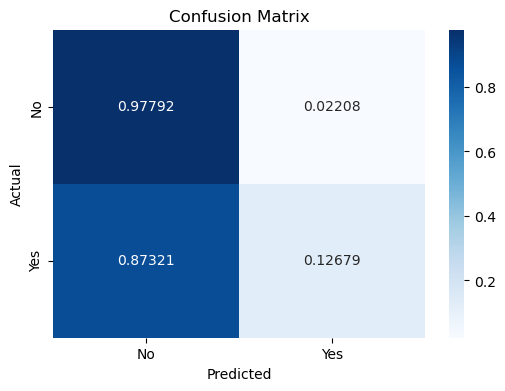

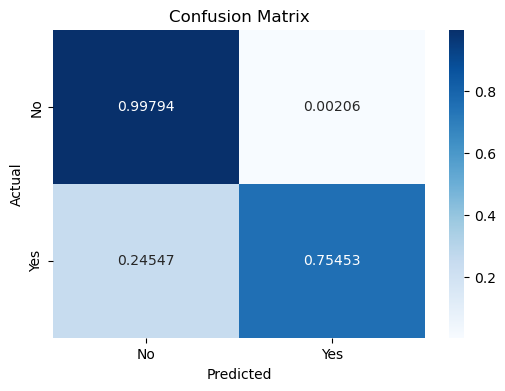

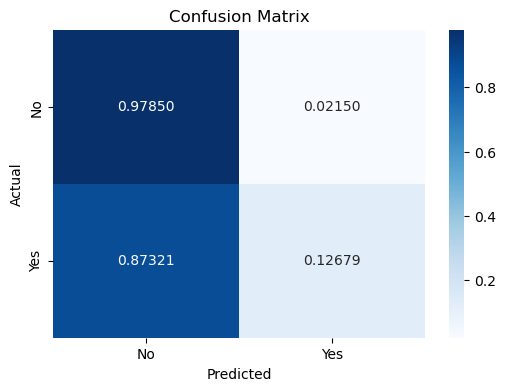

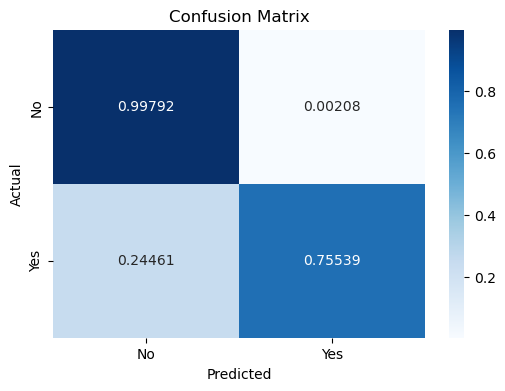

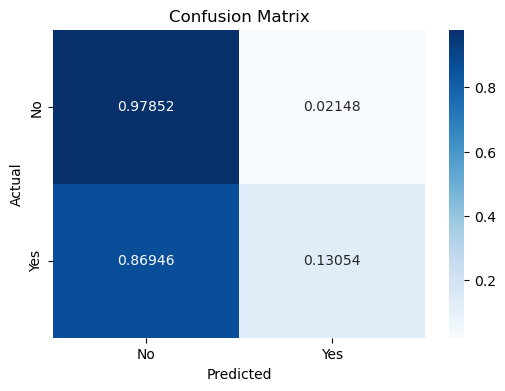

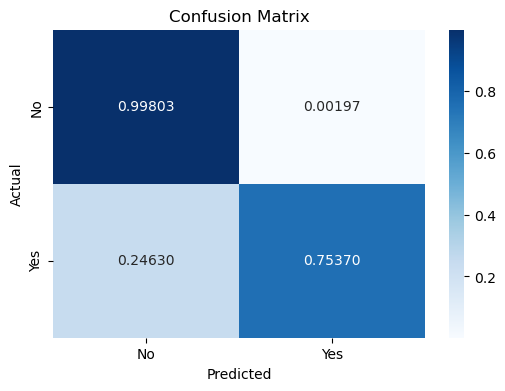

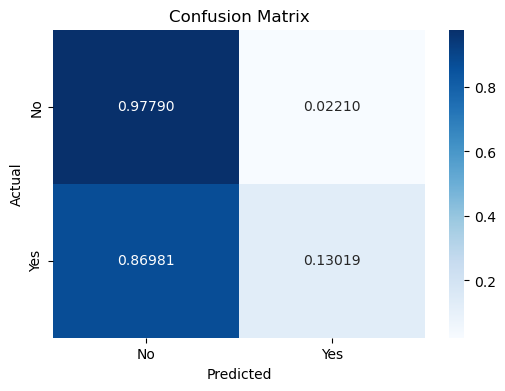

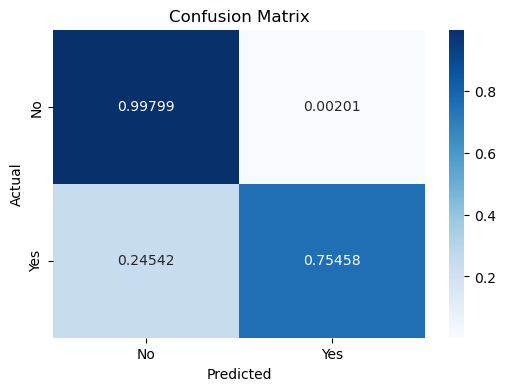

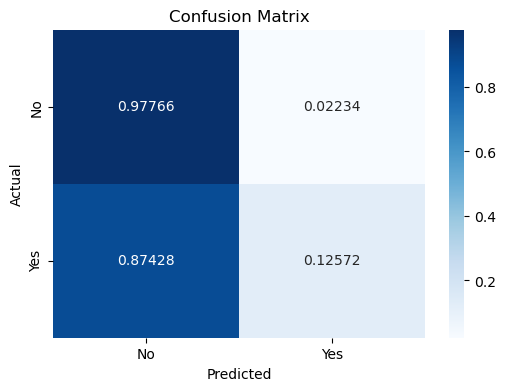

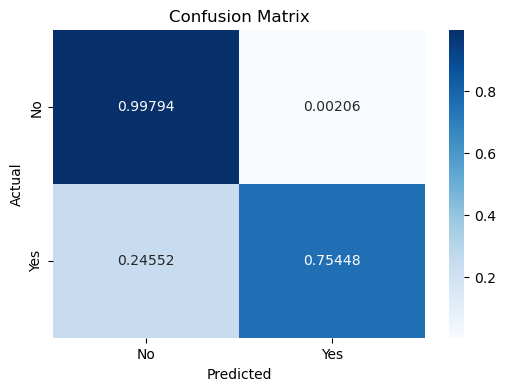

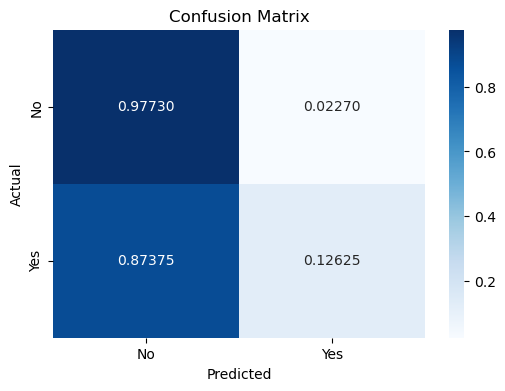

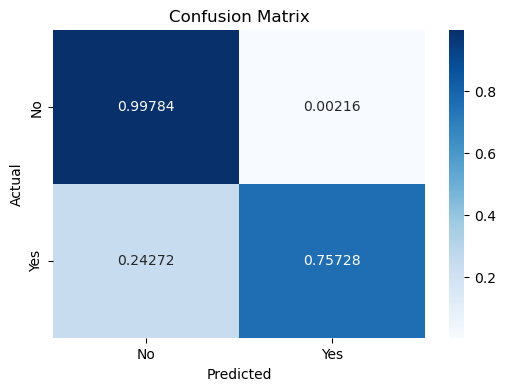

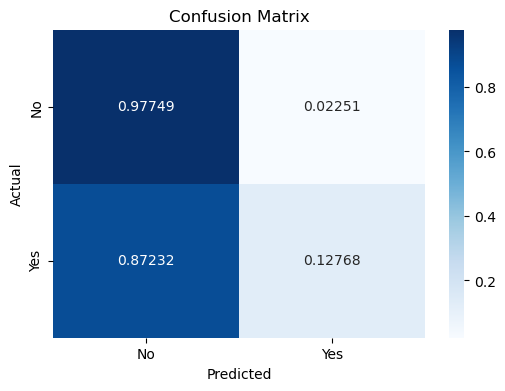

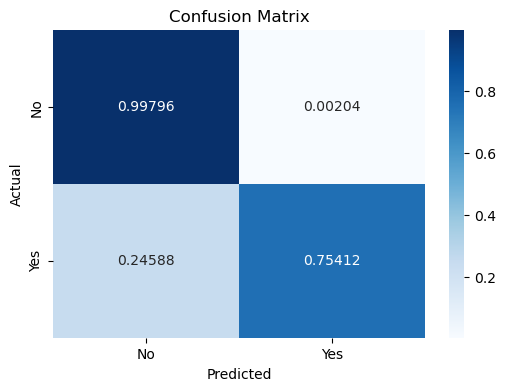

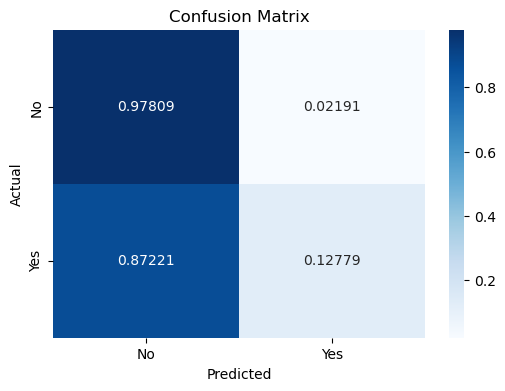

In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, roc_auc_score
import os
import numpy as np

# Load the CSV file
data = pd.read_csv('heart_2020_cleaned.csv')

# Identify categorical columns (excluding the target column 'HeartDisease')
categorical_columns = data.select_dtypes(include=['object']).columns.drop('HeartDisease')

# Define the transformer for one-hot encoding
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='passthrough'  # This leaves the rest of the columns (numerical) unchanged
)

# Apply the transformations to the data
X = column_transformer.fit_transform(data.drop('HeartDisease', axis=1))

# Encode the target variable ('HeartDisease') to numerical values
y = data['HeartDisease'].map({'Yes': 1, 'No': 0})

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the number of folds for StratifiedKFold
n_splits = 10

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


# With this line for Random Forest
model = RandomForestClassifier(random_state=42)


# Define the plot_confusion_matrix function
def plot_confusion_matrix(cm, class_names, save_path=None):
    # Configure the figure and plot the confusion matrix
    fig, ax = plt.subplots(figsize=(6, 4))  # Smaller figure size
    sns.heatmap(cm, annot=True, fmt='.5f', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title('Confusion Matrix')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

import os
import pickle

# Create the directory if it doesn't exist
directory = 'images_ConfusionMatrix'
if not os.path.exists(directory):
    os.makedirs(directory)

# Create the 'results' directory inside 'images_ConfusionMatrix'
results_directory = os.path.join(directory, 'results')
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

# Specify the result file path
result_filename = os.path.join(results_directory, 'classification_report_rf5_all_folds.txt')

# Open the result file for writing
with open(result_filename, 'w') as result_file:
    # Write information text at the beginning
    info_text = "RF-CLASSIFIER MODEL TRAINING \n \n"

    # Print the number of original rows and columns
    num_original_rows, num_original_cols = data.shape
    info_text += f"Number of original rows: {num_original_rows}\n"
    info_text += f"Number of original columns: {num_original_cols}\n \n"

    # Write the information text to the result file
    result_file.write(info_text)

    # Initialize variables to store aggregated metrics
    avg_auc_test = 0
    avg_acc_test = 0
    avg_mcc_test = 0
    avg_auc_train = 0
    avg_acc_train = 0
    avg_mcc_train = 0
    auc_test_values = []
    acc_test_values = []
    mcc_test_values = []
    report_test_list = []
    cm_test_normalized_list = []

    # Loop through the folds
    for fold, (train_idx, test_idx) in enumerate(stratified_kfold.split(X_train, y_train), 1):
        X_fold_train, X_fold_test = X_train[train_idx], X_train[test_idx]
        y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

        # Train the model
        model.fit(X_fold_train, y_fold_train)

        # Predict on the test set
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_fold_train)

        # Generate classification report and confusion matrix for test set
        report_test = classification_report(y_test, y_pred_test, output_dict=True)
        cm_test = confusion_matrix(y_test, y_pred_test)

        # Generate classification report and confusion matrix for training set
        report_train = classification_report(y_fold_train, y_pred_train, output_dict=True)
        cm_train = confusion_matrix(y_fold_train, y_pred_train)

        # Calculate additional metrics on the test set
        auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test))
        acc_test = accuracy_score(y_test, y_pred_test)
        mcc_test = matthews_corrcoef(y_test, y_pred_test)

        # Calculate additional metrics on the training set
        auc_train = roc_auc_score(y_fold_train, model.predict_proba(X_fold_train)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_fold_train))
        acc_train = accuracy_score(y_fold_train, y_pred_train)
        mcc_train = matthews_corrcoef(y_fold_train, y_pred_train)

        # Aggregate metrics
        avg_auc_test += auc_test
        avg_acc_test += acc_test
        avg_mcc_test += mcc_test
        avg_auc_train += auc_train
        avg_acc_train += acc_train
        avg_mcc_train += mcc_train

        # Save metrics to file
        result_file.write(f"\n\nFold {fold} Metrics:\n")
        result_file.write(f"AUC (Test): {auc_test:.5f}\n")
        result_file.write(f"Accuracy (Test): {acc_test:.5f}\n")
        result_file.write(f"MCC (Test): {mcc_test:.5f}\n \n")

        result_file.write(f"AUC (Train): {auc_train:.5f}\n")
        result_file.write(f"Accuracy (Train): {acc_train:.5f}\n")
        result_file.write(f"MCC (Train): {mcc_train:.5f}\n")

        # Save the classification report to the result file for test set
        result_file.write(f"\n\nFold {fold} Classification Report (Test):\n")
        result_file.write(classification_report(y_test, y_pred_test, digits=5))
        result_file.write("\n")

        # Save the confusion matrix to the result file for test set
        result_file.write(f"\n\nFold {fold} Confusion Matrix (Test):\n")
        for row in cm_test:
            result_file.write(" ".join("{:>8}".format(num) for num in row) + '\n')
        result_file.write("\n")

        # Normalize the confusion matrix for test set
        cm_test_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

        # Save confusion matrix plot to file for test set
        cm_filename_test = os.path.join(directory, f'fiveso/fold_{fold}_confusion_matrix_rf_test.png')
        plot_confusion_matrix(cm_test_normalized, class_names=['No', 'Yes'], save_path=cm_filename_test)
        print(f"Confusion matrix plot saved to: {os.path.abspath(cm_filename_test)}")

        # Save the classification report to the result file for training set
        result_file.write(f"\n\nFold {fold} Classification Report (Train):\n")
        result_file.write(classification_report(y_fold_train, y_pred_train, digits=5))
        result_file.write("\n")

        # Save the confusion matrix to the result file for training set
        result_file.write(f"\n\nFold {fold} Confusion Matrix (Train):\n")
        for row in cm_train:
            result_file.write(" ".join("{:>8}".format(num) for num in row) + '\n')
        result_file.write("\n")

        # Normalize the confusion matrix for training set
        cm_train_normalized = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]

        # Save confusion matrix plot to file for training set
        cm_filename_train = os.path.join(directory, f'fiveso/fold_{fold}_confusion_matrix_rf_train.png')
        plot_confusion_matrix(cm_train_normalized, class_names=['No', 'Yes'], save_path=cm_filename_train)
        print(f"Confusion matrix plot saved to: {os.path.abspath(cm_filename_train)}")

        # Print a separator between folds
        result_file.write("\n" + "="*40 + "\n")

        # Append classification report and confusion matrix to lists
        report_test_list.append(report_test)
        cm_test_normalized_list.append(cm_test_normalized)

        # Save metrics for later calculation of standard deviation
        auc_test_values.append(auc_test)
        acc_test_values.append(acc_test)
        mcc_test_values.append(mcc_test)

    # Calculate averages for classification report metrics
    avg_auc_test /= n_splits
    avg_acc_test /= n_splits
    avg_mcc_test /= n_splits

    # Format the averages to the desired number of decimal places
    avg_auc_formatted = "{:.5f}".format(avg_auc_test)
    avg_acc_formatted = "{:.5f}".format(avg_acc_test)
    avg_mcc_formatted = "{:.5f}".format(avg_mcc_test)

    # Save the average metrics to the result file
    result_file.write("\n\nAverage Metrics (Test):\n")
    result_file.write(f"Average AUC: {avg_auc_formatted}\n")
    result_file.write(f"Average Accuracy: {avg_acc_formatted}\n")
    result_file.write(f"Average MCC: {avg_mcc_formatted}\n")
    
    # Calculate standard deviation for classification report metrics
    std_auc_test = np.std(auc_test_values)
    std_acc_test = np.std(acc_test_values)
    std_mcc_test = np.std(mcc_test_values)

    # Format the standard deviations to the desired number of decimal places
    std_auc_formatted = "{:.5f}".format(std_auc_test)
    std_acc_formatted = "{:.5f}".format(std_acc_test)
    std_mcc_formatted = "{:.5f}".format(std_mcc_test)

    # Save the standard deviations to the result file
    result_file.write("\n\nStandard Deviation of Metrics (Test):\n")
    result_file.write(f"Standard Deviation AUC: {std_auc_formatted}\n")
    result_file.write(f"Standard Deviation Accuracy: {std_acc_formatted}\n")
    result_file.write(f"Standard Deviation MCC: {std_mcc_formatted}\n")


    # Save the average confusion matrix plot to file for test set
    avg_cm_test_normalized = np.mean(cm_test_normalized_list, axis=0)
    cm_filename_avg_test = os.path.join(directory, 'average_confusion_matrix_rf_test.png')
    plot_confusion_matrix(avg_cm_test_normalized, class_names=['No', 'Yes'], save_path=cm_filename_avg_test)
    print(f"Average confusion matrix plot saved to: {os.path.abspath(cm_filename_avg_test)}")

    # Save the average classification report to a separate file
    avg_result_filename = os.path.join(results_directory, 'average_classification_report_rf_test.txt')
    with open(avg_result_filename, 'w') as avg_result_file:
        avg_result_file.write("Average Classification Report (Test):\n")
        avg_result_file.write(f"{'':<11}precision    recall  f1-score   support\n\n")

        # Extracting the average classification report values
        avg_precision_test = report_test_list[0]['weighted avg']['precision']
        avg_recall_test = report_test_list[0]['weighted avg']['recall']
        avg_f1_test = report_test_list[0]['weighted avg']['f1-score']

        # Writing the values to the file
        avg_result_file.write(f"{'0':<11}{avg_precision_test:.5f}   {avg_recall_test:.5f}   {avg_f1_test:.5f}   {report_test_list[0]['weighted avg']['support']}\n")

        avg_precision_test = report_test_list[1]['weighted avg']['precision']
        avg_recall_test = report_test_list[1]['weighted avg']['recall']
        avg_f1_test = report_test_list[1]['weighted avg']['f1-score']

        avg_result_file.write(f"{'1':<11}{avg_precision_test:.5f}   {avg_recall_test:.5f}   {avg_f1_test:.5f}   {report_test_list[1]['weighted avg']['support']}\n\n")

        avg_result_file.write(f"{'accuracy':<11}{avg_acc_test:.5f}\n")
        avg_result_file.write(f"{'macro avg':<11}{avg_precision_test:.5f}   {avg_recall_test:.5f}   {avg_f1_test:.5f}   {len(y_test)}\n")
        avg_result_file.write(f"{'weighted avg':<11}{avg_precision_test:.5f}   {avg_recall_test:.5f}   {avg_f1_test:.5f}   {len(y_test)}\n")
